In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import numpy as np
from utility import *
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [14]:
df_raw = pd.read_csv('data/raw/BankChurners.csv')
df_raw.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [15]:
# dropping irrelevant columns
df = df_raw.drop(axis='columns',columns=['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2', 'CLIENTNUM'])

In [16]:
df['id'] = np.arange(df.shape[0])
first_col = df.pop('id')
df.insert(0, 'id', first_col)

In [17]:
def visualize_distribution(df, column):
    # Initialise the subplot function using number of rows and columns
    fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(15, 5))
    fig.suptitle(column)
    ax[0].boxplot(df[column], vert=False)
    ax[1].hist(df[column], bins=(round(1 + 3.322 * math.log(len(df[column]), 10)))) # bins amount chosen by Sturge's rule
    fig.tight_layout()

def visualize_distribution_compact(df, numerical_columns):
    plt.figure(figsize=(28,40))
    b = 0
    for i in numerical_columns:
        b+=1
        plt.subplot(5,3,b)
        plt.hist(df[i])
        plt.title(i)


def visualize_distribution_cat(df, column):
    fig, ax = plt.subplots(1, tight_layout=True, figsize=(15, 5))
    fig.suptitle(column)
    df[column].value_counts(sort=False).plot(kind="bar", ax=ax)



In [18]:
numerical_columns = df._get_numeric_data().columns.to_list()
categorical_columns = list(set(df.columns) - set(numerical_columns))
numerical_columns.remove('id')
categorical_columns_indices = [df.columns.get_loc(c) for c in categorical_columns if c in df]
numerical_columns_indices = [df.columns.get_loc(c) for c in numerical_columns if c in df]


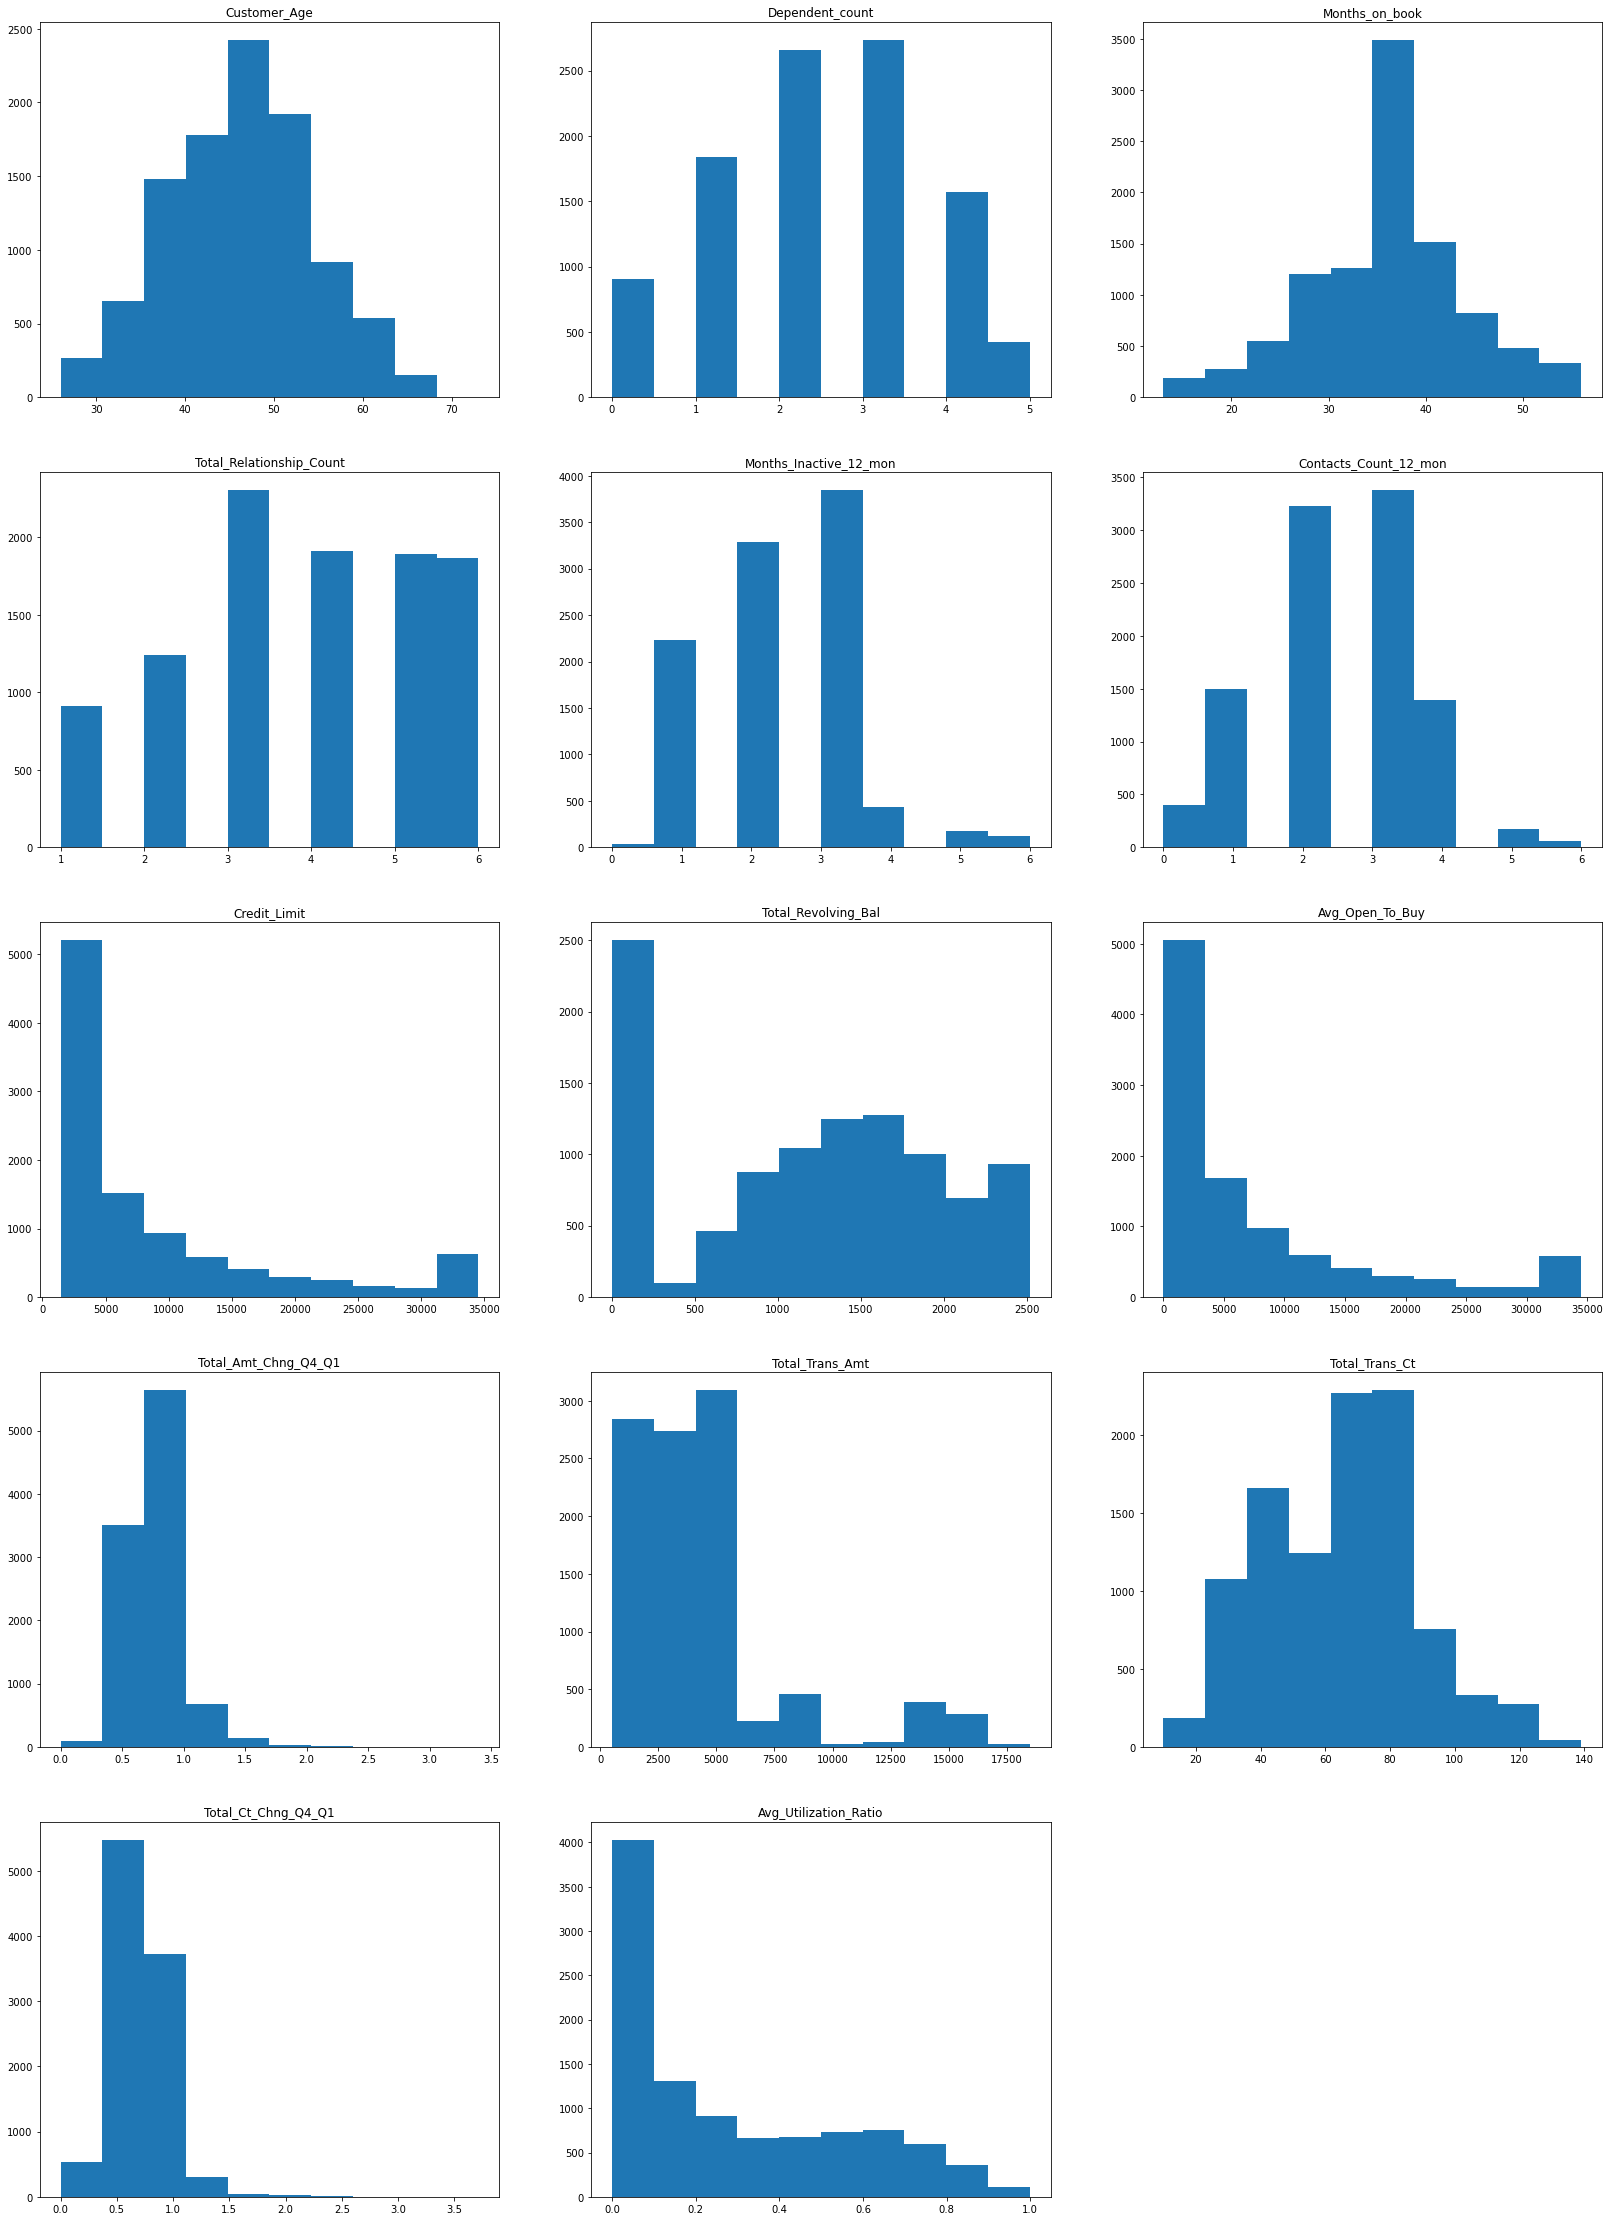

In [19]:
visualize_distribution_compact(df, numerical_columns)

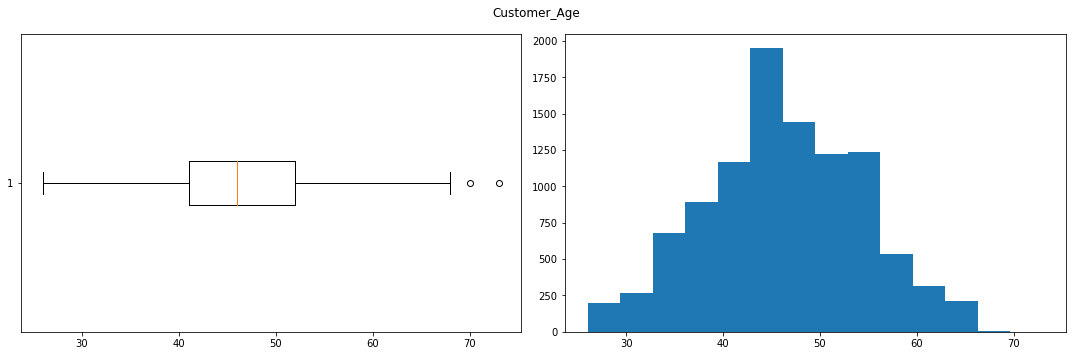

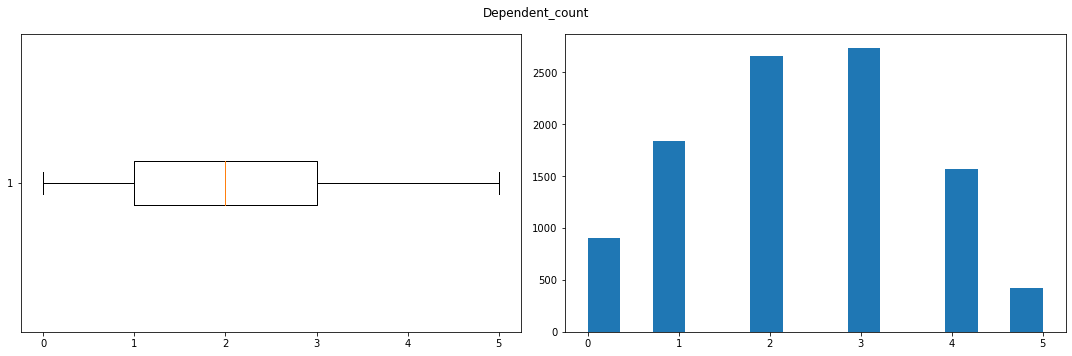

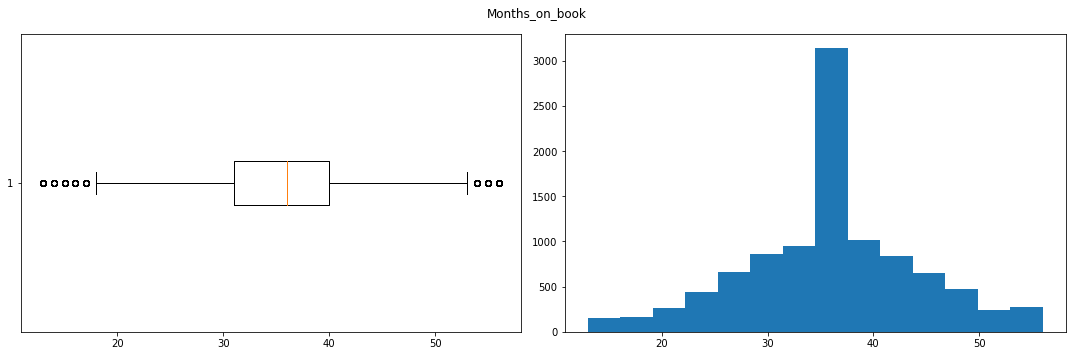

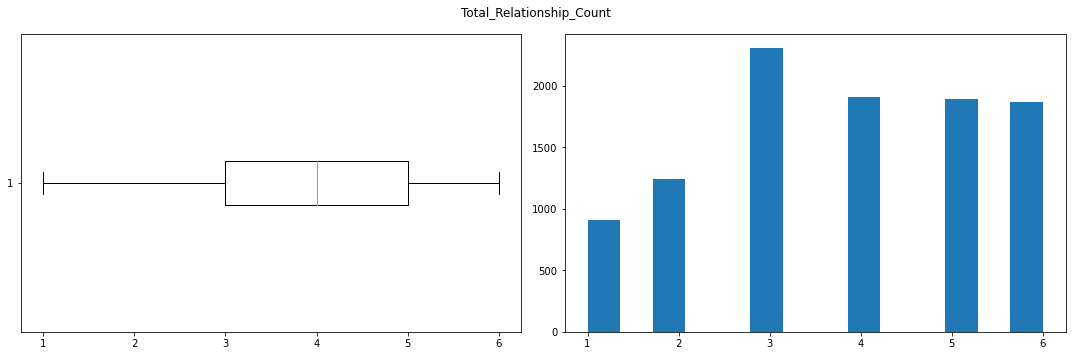

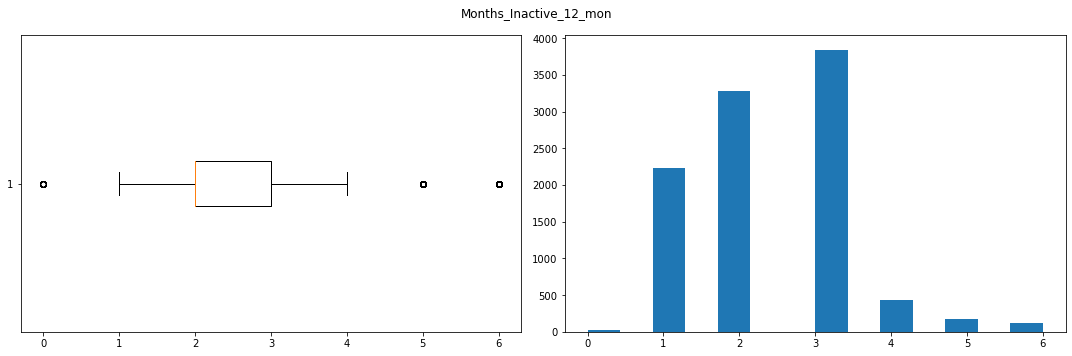

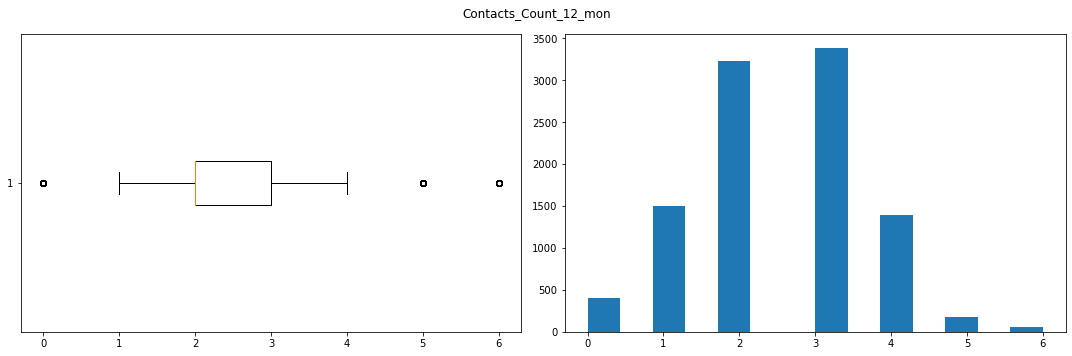

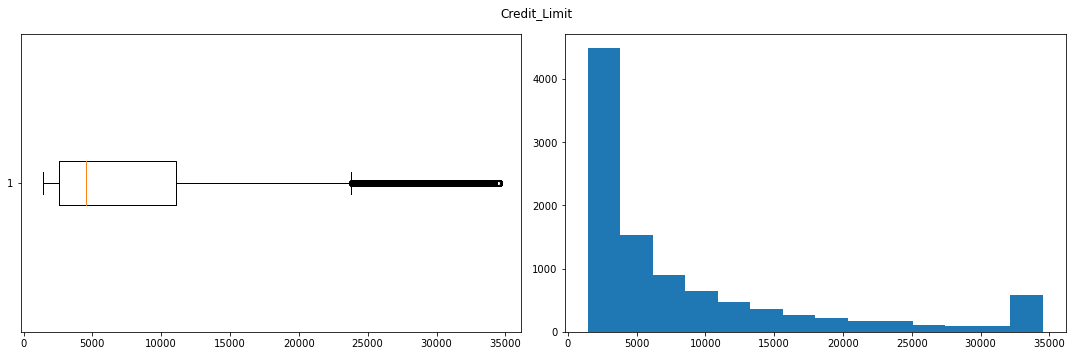

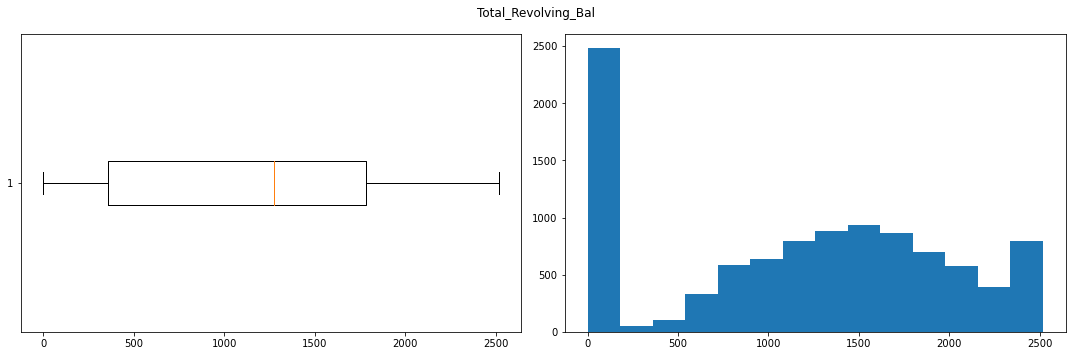

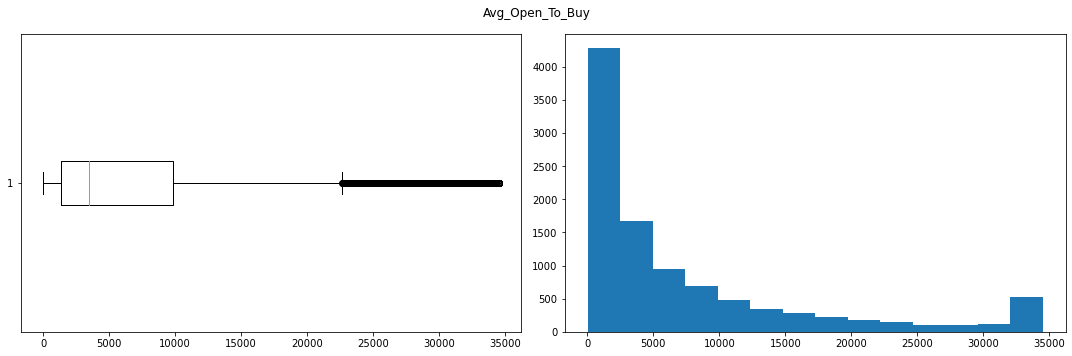

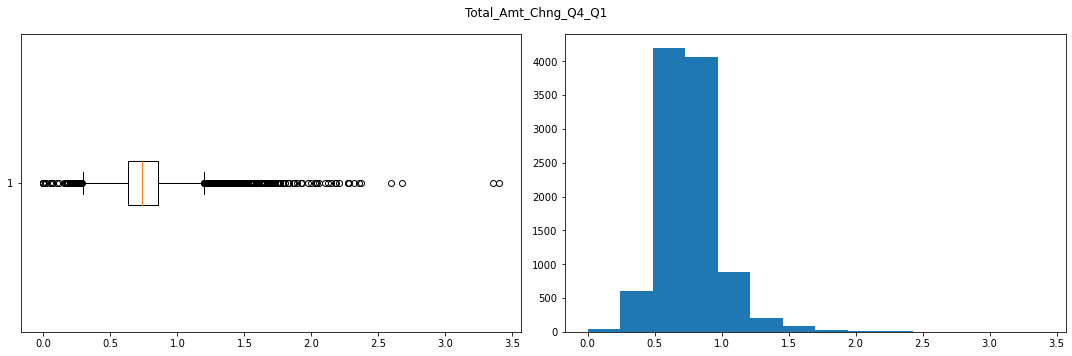

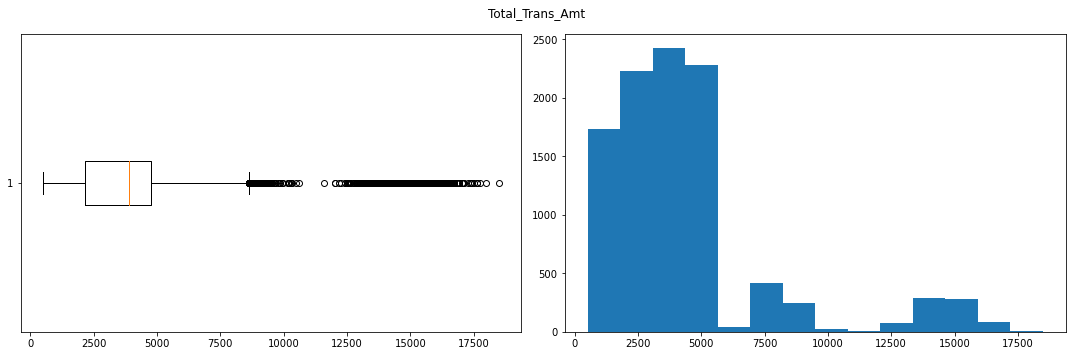

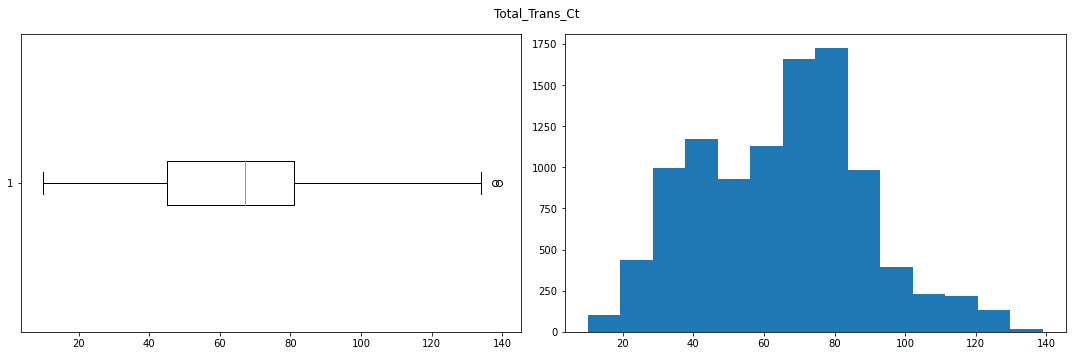

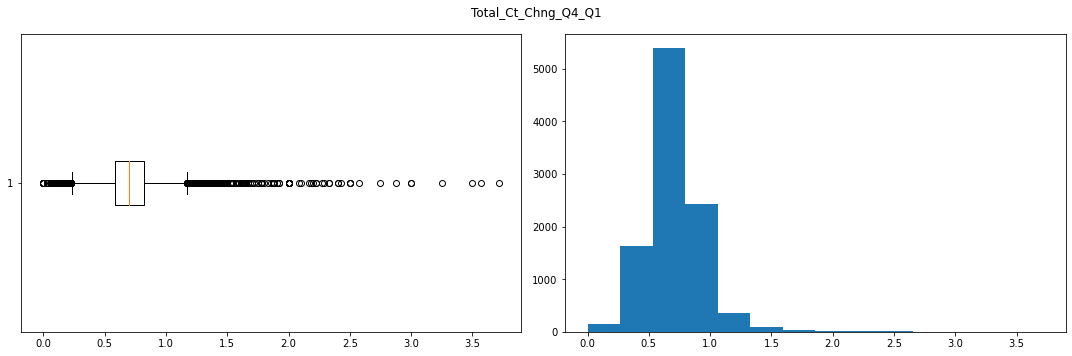

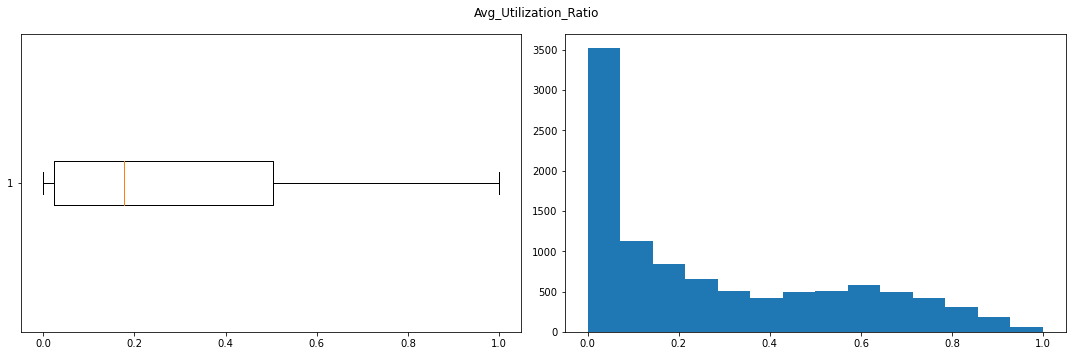

In [20]:
for column in numerical_columns:
    visualize_distribution(df, column)

### Outliers detection

We will go through all the numerical columns and use the function to assign the skewed values to quantiles. The function uses a logarithmic transformation as well as the 5th and 95th percentile. Logarithmic transformation helps address skewed data by reducing the impact of extreme values and making the distribution more symmetrical. The 5th and 95th percentile approach effectively identifies and handles outliers, ensuring that statistical analyses and models are not unduly influenced by extreme observations. These techniques strike a balance between addressing outliers and preserving the integrity of the data.

In [21]:
def outliers(inputed_data, column):
    data = inputed_data.copy(deep = True)
    value = stats.skew(data[column]) 
    
    if ((value < -2) or (value > 2)):  
        minimum = data[column].min()
        minimum = minimum + (-minimum - minimum)
        data[column] = np.log(data[column]+minimum)
    perc_95 = data[column].quantile(.95)   
    perc_05 =  data[column].quantile(.05)
    data.loc[data[column] < perc_05, column] = perc_05
    data.loc[data[column] > perc_95, column] = perc_95
    return data

def remove_outlier(data, column_name):
    q05, q95 = data[column_name].quantile(0.05), data[column_name].quantile(0.95)
    q = q95 - q05
    remove = q * 1.5
    lower, upper = q05 - remove, q95 + remove
    filtered_data = data.loc[(data[column_name] > lower) & (data[column_name] < upper)]
    num_outliers_removed = len(data) - len(filtered_data)
    print(f"Number of outliers removed in column {column_name}: {num_outliers_removed}")
    return filtered_data

In [24]:
for column_name in numerical_columns:
    df = remove_outlier(df,column_name)

Number of outliers removed in column Customer_Age: 0
Number of outliers removed in column Dependent_count: 0
Number of outliers removed in column Months_on_book: 0
Number of outliers removed in column Total_Relationship_Count: 0
Number of outliers removed in column Months_Inactive_12_mon: 0
Number of outliers removed in column Contacts_Count_12_mon: 0
Number of outliers removed in column Credit_Limit: 0
Number of outliers removed in column Total_Revolving_Bal: 0
Number of outliers removed in column Avg_Open_To_Buy: 0
Number of outliers removed in column Total_Amt_Chng_Q4_Q1: 16
Number of outliers removed in column Total_Trans_Amt: 0
Number of outliers removed in column Total_Trans_Ct: 0
Number of outliers removed in column Total_Ct_Chng_Q4_Q1: 20
Number of outliers removed in column Avg_Utilization_Ratio: 0


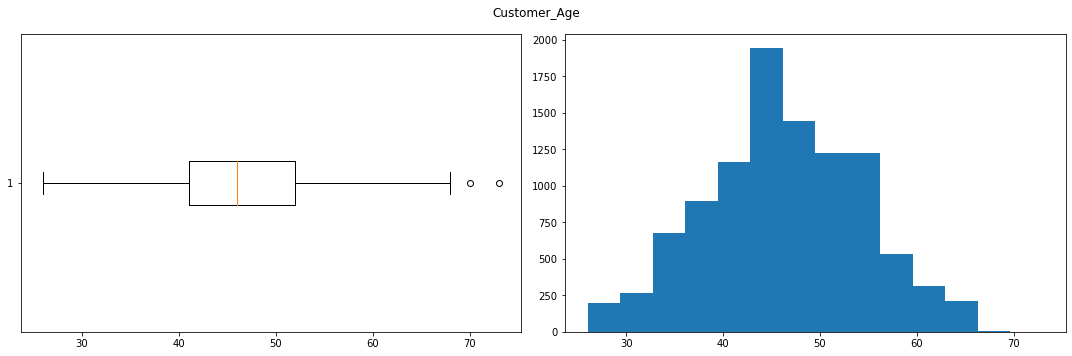

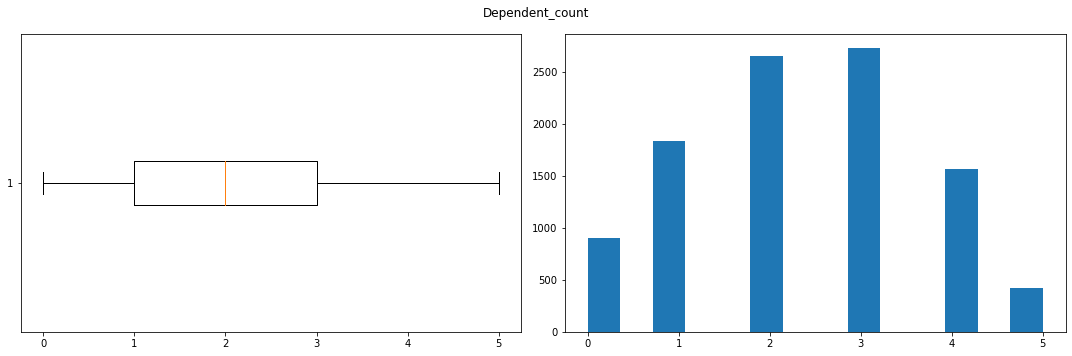

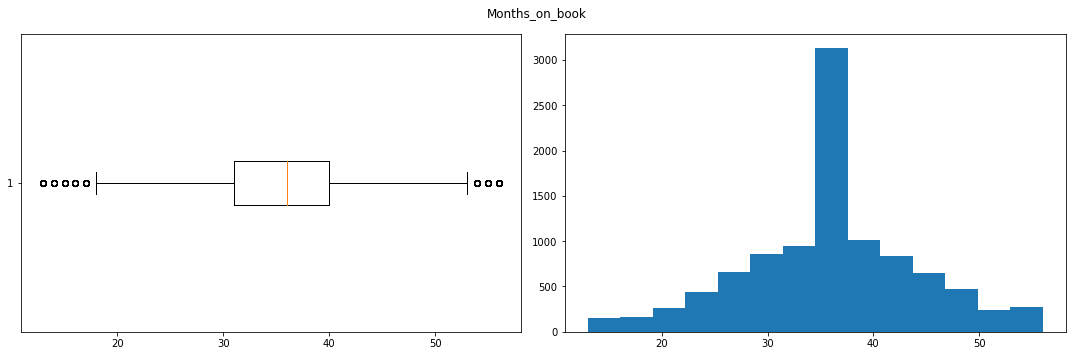

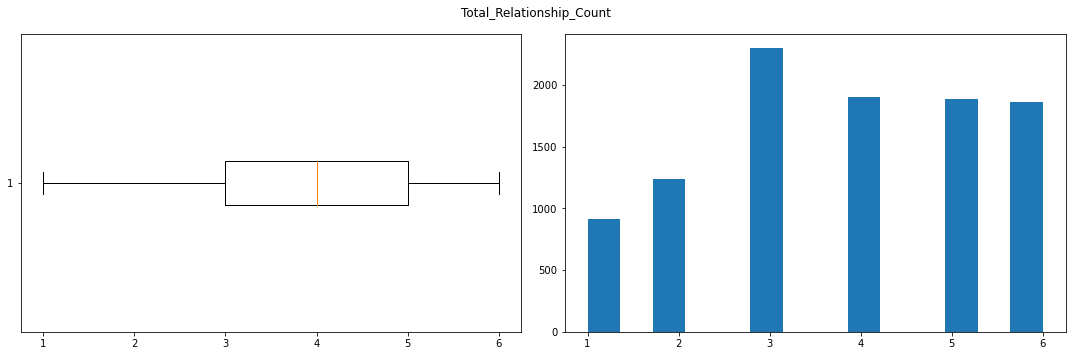

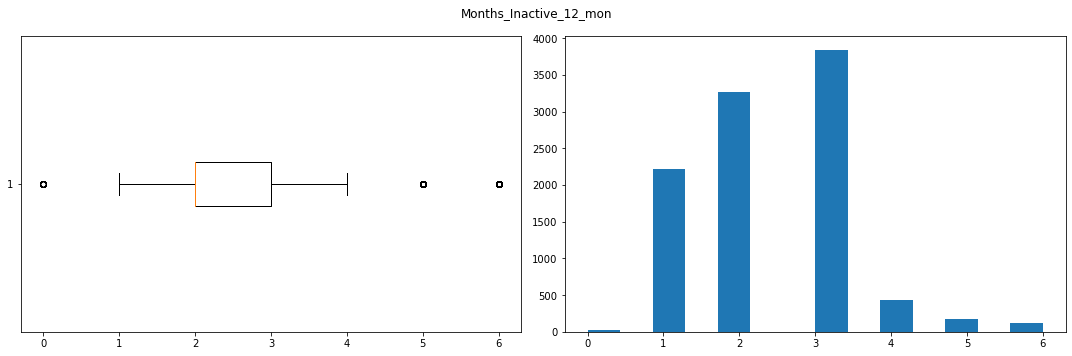

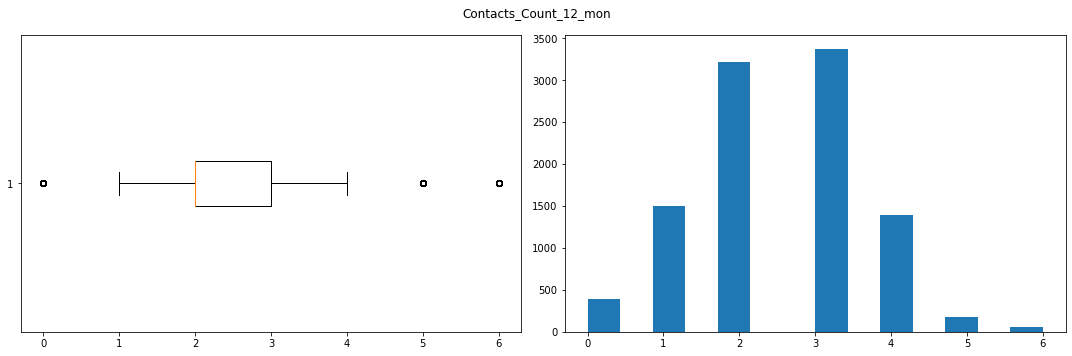

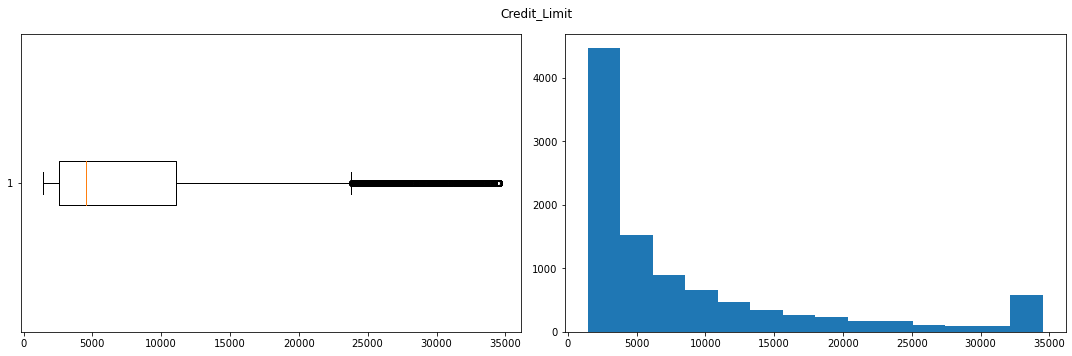

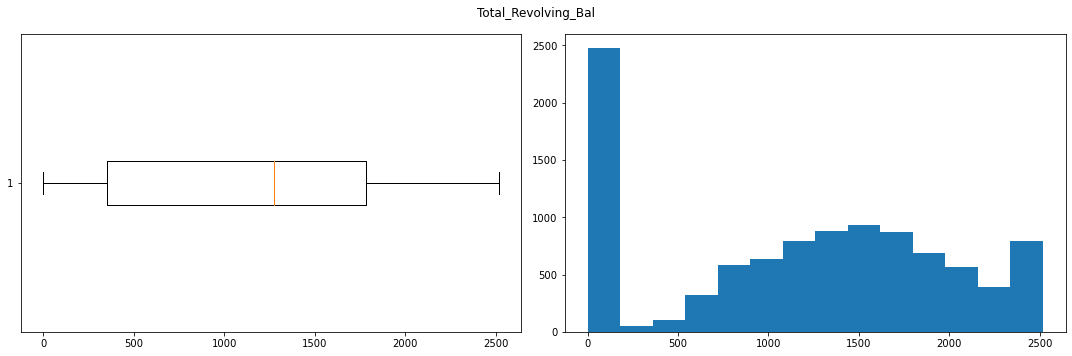

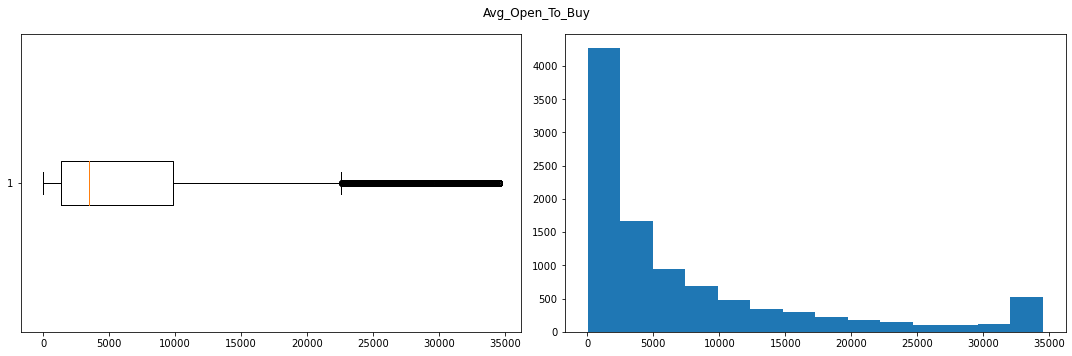

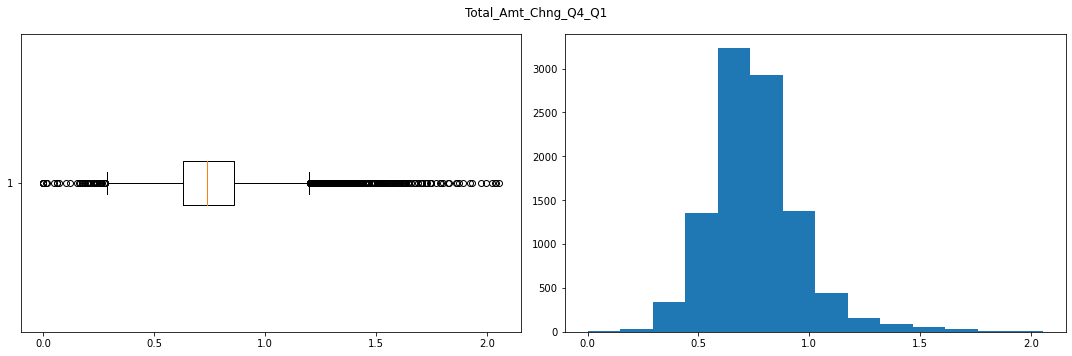

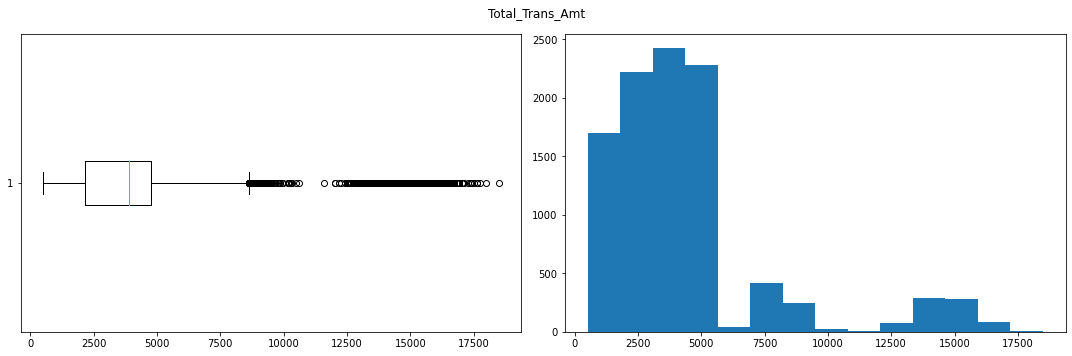

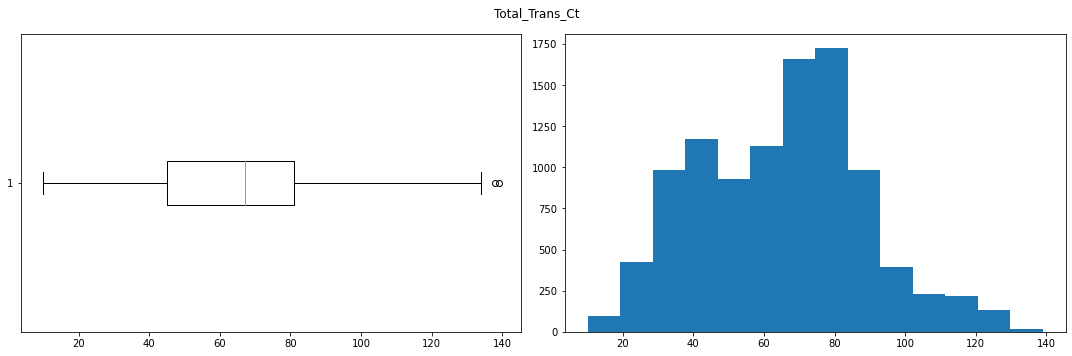

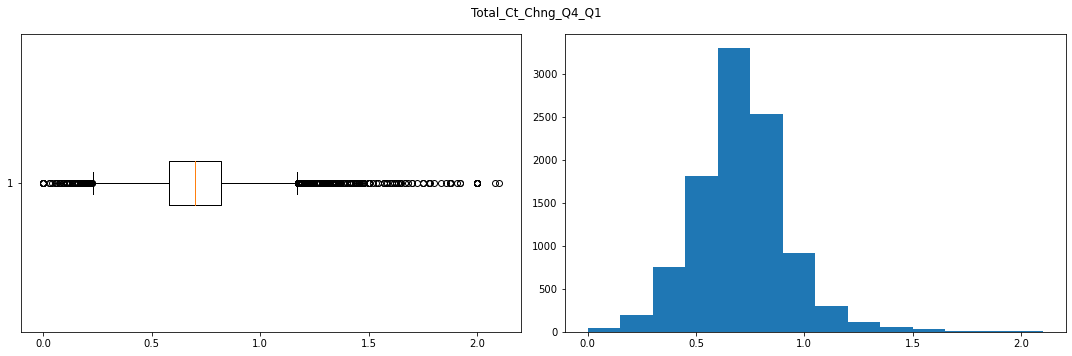

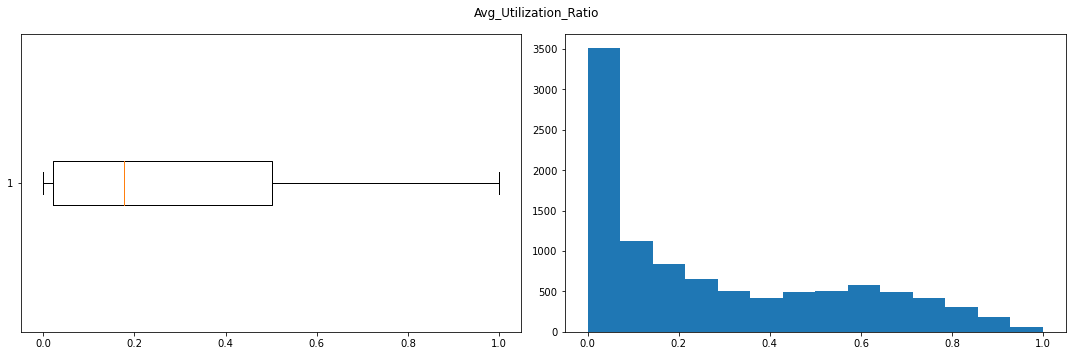

In [25]:
for column in numerical_columns:
    visualize_distribution(df, column)